<a href="https://colab.research.google.com/github/RabaDaba1/pooling-layer-analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [41]:
import os
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt

# Constants

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
BATCH_SIZE = 64
NUM_WORKERS = 0

In [4]:
ROOT_DIR = Path('.')
DATA_DIR = ROOT_DIR / 'data'
REPORTS_DIR = ROOT_DIR / 'reports'
MODELS_DIR = REPORTS_DIR / 'models'
RESULTS_DIR = REPORTS_DIR / 'results'
RUNS_DIR = REPORTS_DIR / 'runs'

# Data loading

In [5]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)]
)
val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5)]
)
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

In [6]:
train_proportion = 0.9
num_train = 50000

indices = list(range(num_train))
split = int(np.floor(train_proportion * num_train))
np.random.shuffle(indices)

train_idx, val_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [7]:

train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True,
                                 download=True, transform=train_transform)

val_dataset = datasets.CIFAR10(root=DATA_DIR, train=True,
                               download=True, transform=val_transform)

test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False,
                                download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          sampler=train_sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        sampler=val_sampler, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS)

# Aggregating functions

In [9]:
def arithmetic_mean(X, dim, keepdim):
    return torch.mean(X, dim, keepdim)

In [10]:
def minimum(X, dim, keepdim):
    return torch.min(X, dim, keepdim).values

In [11]:
def product(X, dim, keepdim):
    return torch.prod(X, dim=dim, keepdim=keepdim)

In [12]:
def t_norm_lukasiewicz(X, dim, keepdim):
    sum_X = torch.sum(X, dim=dim, keepdim=keepdim) - 1
    return torch.max(sum_X, torch.tensor(0, device=X.device))

In [75]:
def t_norm_hamacher(tensor, dim, keepdim=False): 
    tensor_shape = list(tensor.shape)
    tensor_shape.pop(dim)
    out_tensor = tensor.new_zeros(tensor_shape)
    # Indexar la útlima dimensión facilita la legibilidad del código (tendríamos que usar torch.index_select en caso contrario)
    if (dim == -1) or (dim == len(tensor.shape)-1):
        out_tensor = tensor[..., 0] # Tensor auxiliar donde acumularemos la salida (hará las veces de x)
        for i in range(1, tensor.shape[dim]):  # La t-conorma es asociativa: Trataremos los elementos de 2 en 2
            # Dado que la t-norma es asociativa, trataremos los elementos de 2 en 2. En cada iteración:
            x = out_tensor
            y = tensor[..., i]
            diff_indices = torch.logical_or(x != 0, y != 0)
            # if x == y == 0 -> 0 (we already have it)
            # otherwise -> T(a, b) = (ab) / (a+b-ab)
            out_tensor[diff_indices] = (
                torch.mul(x[diff_indices], y[diff_indices]) / (x[diff_indices] + y[diff_indices] - torch.mul(x[diff_indices], y[diff_indices])))
            
    else:
        raise Exception('Use dim=-1')
    # If keepdims is True, expand the reduced dimension to size 1
    if keepdim:
        out_tensor = out_tensor.unsqueeze(dim)
    
    return out_tensor

In [14]:
def maximum(X, dim, keepdim):
    return torch.max(X, dim, keepdim).values

In [15]:
def t_conorm_lukasiewicz(X, dim, keepdim):
    sum_X = torch.sum(X, dim=dim, keepdim=keepdim)
    return torch.min(sum_X, torch.tensor(1.0, device=X.device))

In [86]:
def t_conorm_hamacher(X, dim = -1, keepdim = False):
    tensor_shape = list(tensor.shape)
    tensor_shape.pop(dim)
    out_tensor = tensor.new_zeros(tensor_shape)
    ones = tensor.new_ones(tensor_shape)
    # Indexar la Ãºtlima dimensiÃ³n facilita la legibilidad del cÃ³digo (tendrÃ­amos que usar torch.index_select en caso contrario)
    if (dim == -1) or (dim == len(tensor.shape)-1):
        out_tensor = tensor[..., 0] # Tensor auxiliar donde acumularemos la salida (harÃ¡ las veces de x)
        for i in range(1, tensor.shape[dim]):  # La t-conorma es asociativa: Trataremos los elementos de 2 en 2
            # Dado que la t-conorma es asociativa, trataremos los elementos de 2 en 2. En cada iteraciÃ³n:
            x = out_tensor
            y = tensor[..., i]
            diff_indices = torch.where(torch.abs(torch.mul(x, y)-1) > 1e-9) # Devuelve los Ã­ndices de los elementos para los cuÃ¡les x*y-1 > 0 (condiciÃ³n de la funciÃ³n por partes)
            # Asignamos los valores en funciÃ³n de las condiciones
            # if ab == 1 -> T(a, b) = 1
            out_tensor = ones  # Por defecto, asumimos que todos los valores caen en el caso x*y-1=0
            # otherwise -> T(a, b) = (2ab - a - b) / (ab - 1)
            out_tensor[diff_indices] = (
                2 * torch.mul(x[diff_indices], y[diff_indices]) - x[diff_indices] - y[diff_indices]) / (
                torch.mul(x[diff_indices], y[diff_indices]) - 1)  # Corregimos los valores para los cuÃ¡les x*y-1>0 (los que corresponden a los Ã­ndices de diff_indices)
    else:
        # El cÃ³digo serÃ­a idÃ©ntico, sustituyendo tensor[..., 0] por torch.index_select(tensor, dim, tensor.new_tensor([0], dtype=torch.int)).squeeze(dim)
        # torch.index_select(tensor, dim, tensor.new_tensor([0], dtype=torch.int)).squeeze(dim) indexa todos los elementos de la dimensiÃ³n dim
        # NO HACE FALTA IMPLEMENTARLO
        raise Exception('Utilizar la versiÃ³n con dim=-1')
    if keepdim:
        torch.unsqueeze(out_tensor, dim=dim)
    return out_tensor

In [88]:
def u_min_max(tensor, dim = -1, keepdim = False):
    
    tensor_shape = list(tensor.shape)
    tensor_shape.pop(dim)
    out_tensor = tensor.new_zeros(tensor_shape)
    ones = tensor.new_ones(tensor_shape)
    # Indexar la Ãºtlima dimensiÃ³n facilita la legibilidad del cÃ³digo (tendrÃ­amos que usar torch.index_select en caso contrario)
    if (dim == -1) or (dim == len(tensor.shape)-1):
        out_tensor = tensor[..., 0] # Tensor auxiliar donde acumularemos la salida (harÃ¡ las veces de x)
        for i in range(1, tensor.shape[dim]):  # La t-conorma es asociativa: Trataremos los elementos de 2 en 2
            # Dado que la t-conorma es asociativa, trataremos los elementos de 2 en 2. En cada iteraciÃ³n:
            x = out_tensor
            y = tensor[..., i]
            cond1 = torch.logical_or(tensor1 < 0, tensor1 > 0.5)
            cond2 = torch.logical_or(tensor2 < 0, tensor2 > 0.5)
            diff_indices = torch.logical_or(cond1, cond2)
            # Asignamos los valores en funciÃ³n de las condiciones
            # if a, b in [0,0'5]^2 -> U(a, b) = min(a,b)
            out_tensor = torch.min(x,y).values  
            # otherwise -> U(a, b) = max(a,b)
            out_tensor[diff_indices] = (torch.max(x,y).values)  
    else:
        raise Exception('Utilizar la versiÃ³n con dim=-1')
    if keepdim:
        torch.unsqueeze(out_tensor, dim=dim)
    return out_tensor

In [87]:
def u_l_l(X, dim = -1, keepdim = False):

    tensor_shape = list(tensor.shape)
    tensor_shape.pop(dim)
    out_tensor = tensor.new_zeros(tensor_shape)
    ones = tensor.new_ones(tensor_shape)
    # Indexar la Ãºtlima dimensiÃ³n facilita la legibilidad del cÃ³digo (tendrÃ­amos que usar torch.index_select en caso contrario)
    if (dim == -1) or (dim == len(tensor.shape)-1):
        out_tensor = tensor[..., 0] # Tensor auxiliar donde acumularemos la salida (harÃ¡ las veces de x)
        for i in range(1, tensor.shape[dim]):  # La t-conorma es asociativa: Trataremos los elementos de 2 en 2
            # Dado que la t-conorma es asociativa, trataremos los elementos de 2 en 2. En cada iteraciÃ³n:
            x = out_tensor
            y = tensor[..., i]
            
            # Condiciones
            cond1 = torch.logical_and(x <= 0.5, y <= 0.5)  # Caso 1: (x, y) en [0, 0.5]^2
            cond2 = torch.logical_and(x >= 0.5, y >= 0.5)  # Caso 2: (x, y) en [0.5, 1]^2
            cond3 = ~(cond1 | cond2)  # Caso 3: En cualquier otro caso

            # Caso 1: max(x + y - 1, 0)
            if cond1.any():
                out_tensor[cond1] = torch.maximum(
                    x[cond1] + y[cond1] - 1, 
                    torch.tensor(0.0, device=tensor.device)
                )

            # Caso 2: min(x + y, 1)
            if cond2.any():
                out_tensor[cond2] = torch.minimum(
                    x[cond2] + y[cond2], 
                    torch.tensor(1.0, device=tensor.device)
                )

            # Caso 3: max(x, y)
            if cond3.any():
                out_tensor[cond3] = torch.maximum(x[cond3], y[cond3])
                
    else:
        raise Exception('Utilizar la versiÃ³n con dim=-1')
    if keepdim:
        torch.unsqueeze(out_tensor, dim=dim)
    return out_tensor

In [19]:
class ChoquetLayer(nn.Module):
    def __init__(self, input_size):
        super(ChoquetLayer, self).__init__()
        self.input_size = input_size
        self.w = None

    def forward(self, x, dim, keepdim):
        input_size = x.size(-1)
        batch_size = x.size(0)

        if self.w is None or self.w.size(0) != batch_size:
            self.w = nn.Parameter(torch.randn(input_size))

        x_sorted, indices = torch.sort(x, descending=True, dim=-1)  # (batch_size, input_size)
        v_Ai = self.compute_v_Ai(indices)  # (batch_size, n+1)
        v_delta = v_Ai[..., :-1] - v_Ai[..., 1:]  # (batch_size, input_size)
        x = torch.sum(x_sorted * v_delta, dim=-1)  # (batch_size)

        if keepdim:
          x.unsqueeze(dim)

        return x

    def compute_v_Ai(self, indices):
        w_sorted = self.w[indices]
        v_Ai = torch.cumsum(w_sorted, dim=-1)
        zeros = torch.zeros(*v_Ai.shape[:-1], 1).to(v_Ai.device)
        v_Ai = torch.cat((zeros, v_Ai), dim=-1)
        return v_Ai

# Layers

In [20]:
class AggPoolingLayer(nn.Module):

    def __init__(self, function, kernel_size, stride, padding= [0,0,0,0], dim = -1, keepdim = False):
        super().__init__()

        # Una tupla de 2 elementos con los tamaños [𝑘1,𝑘2] de cada ventana a tratar
        self.kernel_size = kernel_size

        # Tupla de 2 elementos que indican el número de elementos (en filas y columnas) que
        # deben saltarse tras reducir cada ventana, hasta encontrar la siguiente a tratar.
        self.stride = stride

        # Tupla de 4 elementos de la forma [𝑝𝑎𝑑_𝑙𝑒𝑓𝑡,𝑝𝑎𝑑_𝑟𝑖𝑔ℎ𝑡,𝑝𝑎𝑑_𝑢𝑝,𝑝𝑎𝑑_𝑑𝑜𝑤𝑛] que indica el
        # número de nuevas filas o columnas a añadir a la entrada, previo a aplicar la agregación.
        self.padding = padding

        # Define function and characteristics
        self.function = function
        self.dim = dim
        self.keepdim = keepdim

    def forward(self, X):

        # Normalize
        maximum = torch.max(X)
        minimum = torch.min(X)
        X = (X-minimum)/(maximum-minimum)

        # Añadir columnas/filas según padding
        X_pad = F.pad(X, pad=self.padding, mode='constant', value=0)

        # Vamos extrayendo las ventanas a agregar y colocándolas en filas
        X_aux = X_pad.unfold(2, size=self.kernel_size[0], step=self.stride[0]).unfold(3, size=self.kernel_size[1], step=self.stride[1])

        # Ponemos el formato correcto
        X_aux = X_aux.reshape([X_aux.shape[0], X_aux.shape[1], X_aux.shape[2], X_aux.shape[3], X_aux.shape[4] * X_aux.shape[5]])

        # Agg Func
        Y_temp = self.function(X_aux, dim = self.dim, keepdim = self.keepdim)

        # Denormalize
        Y = minimum + (maximum-minimum) * Y_temp

        return Y

In [21]:
class OWAPoolingLayer(nn.Module):

    def __init__(self, kernel_size, stride, padding= [0,0,0,0], dim = -1, keepdim = False):
        super().__init__()

        # Una tupla de 2 elementos con los tamaños [𝑘1,𝑘2] de cada ventana a tratar
        self.kernel_size = kernel_size

        # Tupla de 2 elementos que indican el número de elementos (en filas y columnas) que
        # deben saltarse tras reducir cada ventana, hasta encontrar la siguiente a tratar.
        self.stride = stride

        # Tupla de 4 elementos de la forma [𝑝𝑎𝑑_𝑙𝑒𝑓𝑡,𝑝𝑎𝑑_𝑟𝑖𝑔ℎ𝑡,𝑝𝑎𝑑_𝑢𝑝,𝑝𝑎𝑑_𝑑𝑜𝑤𝑛] que indica el
        # número de nuevas filas o columnas a añadir a la entrada, previo a aplicar la agregación.
        self.padding = padding

        # Define characteristics
        self.dim = dim
        self.keepdim = keepdim

        # Weights
        self.weight = nn.Parameter(torch.ones(1, self.kernel_size[0] * self.kernel_size[1]))


    def funcionOWA(self, X):

        tensor_ordered = torch.sort(X, descending = True)
        weight_norm = torch.nn.functional.softmax(self.weight, dim = self.dim)
        output = torch.sum(tensor_ordered[0] * weight_norm, dim = self.dim, keepdim = self.keepdim)

        return output

    def forward(self, X):

        # Normalize
        maximum = torch.max(X)
        minimum = torch.min(X)
        X = (X-minimum)/(maximum-minimum)

        # Añadir columnas/filas según padding
        X_pad = F.pad(X, pad=self.padding, mode='constant', value=0)

        # Vamos extrayendo las ventanas a agregar y colocándolas en filas
        X_aux = X_pad.unfold(2, size=self.kernel_size[0], step=self.stride[0]).unfold(3, size=self.kernel_size[1], step=self.stride[1])

        # Ponemos el formato correcto
        X_aux = X_aux.reshape([X_aux.shape[0], X_aux.shape[1], X_aux.shape[2], X_aux.shape[3], X_aux.shape[4] * X_aux.shape[5]])

        # Agg Func
        Y_temp = self.funcionOWA(X_aux)

        # Denormalize
        Y = minimum + (maximum-minimum) * Y_temp

        return Y

# Model

In [ ]:
class LeNetModel(nn.Module):

    def __init__(self, function, conv_filters=[64, 64], linear_sizes=[384, 192], num_classes=10):
        super().__init__()
        self.conv_filters = conv_filters
        
        self.linear_sizes = linear_sizes
        
        self.num_classes = num_classes
        
        # Primera Convolución con conv_filters[0] filtros de tamaño [3, 3] y stride [1, 1] y padding [1, 1].    
        self.conv_1 = torch.nn.Conv2d(in_channels = 3, out_channels = self.conv_filters[0], kernel_size = [3, 3], stride = [1, 1], padding = [1, 1], device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        if function == "OWA":
            # Primer Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_1 = OWAPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
            
            # Segundo Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_2 = OWAPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
            
        elif function == "Choquet": 
            # Primer Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_1 = ChoquetPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
            
            # Segundo Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_2 = ChoquetPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
            
        else:
            # Primer Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_1 = AggPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
            
            # Segundo Pooling con kernel size [2, 2] y stride [2, 2]
            self.pool_2 = AggPoolingLayer(function, kernel_size = [2, 2], stride = [2, 2])
        
        # Segundo Convolución con conv_filters[1] filtros de tamaño [3, 3] y stride [1, 1] y padding [1, 1].
        self.conv_2 = torch.nn.Conv2d(in_channels = self.conv_filters[0], out_channels = self.conv_filters[1], kernel_size = [3, 3], stride = [1, 1], padding = [1, 1], device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        # Primera Capa oculta lineal con conv_filters[1] * 8 * 8 neuronas de entrada y linear_sizes[0] neuronas de salida.
        self.lin_1 = torch.nn.Linear(in_features = self.conv_filters[1] * 8 * 8, out_features = self.linear_sizes[0], bias=True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        # Segunda Capa oculta lineal con linear_sizes[0] neuronas de entrada y linear_sizes[1] neuronas de salida.
        self.lin_2 = torch.nn.Linear(in_features = self.linear_sizes[0], out_features = self.linear_sizes[1], bias=True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        # Capa de salida lineal con linear_sizes[1] neuronas de entrada y num_classes neuronas de salida.
        self.salida = torch.nn.Linear(in_features = self.linear_sizes[1], out_features = self.num_classes, bias=True, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        
    def forward(self, X):
        
        # print(X.shape)
        
        # Ejecutamos primera Convolución 
        X_tras_conv_1 = self.conv_1(X)
        #print("X_tras_conv_1.shape = ", X_tras_conv_1.shape)
        
        # Ejecutamos primer Pooling 
        X_tras_pool_1 = self.pool_1(X_tras_conv_1)
        #print("X_tras_pool_1.shape = ", X_tras_pool_1.shape)
        
        # Ejecutamos segunda Convolución
        X_tras_conv_2 = self.conv_2(X_tras_pool_1)
        #print("X_tras_conv_2.shape = ", X_tras_conv_2.shape)
        
        # Ejecutamos Segundo Pooling
        X_tras_pool_2 = self.pool_2(X_tras_conv_2)
        #print("X_tras_pool_2.shape = ", X_tras_pool_2.shape)
        
        # Antes de la primera capa oculta lineal, se deberá convertir la salida 𝑋 de la capa anterior de tamaño 
        # [batch_size, conv_filters[1], 8, 8] en un tensor de tamaño [batch_size, conv_filters[1] * 8 * 8]
        X_tras_rshp = X_tras_pool_2.reshape([X_tras_pool_2.shape[0], X_tras_pool_2.shape[1] * X_tras_pool_2.shape[2] * X_tras_pool_2.shape[3]])
        #print("X_tras_rshp.shape = ",X_tras_rshp.shape)
        
        # Ejecutamos 1º Capa oculta lineal.
        X_tras_lin_1 = self.lin_1(X_tras_rshp)
        #print("X_tras_lin_1.shape = ", X_tras_lin_1.shape)
        
        # Le aplicamos ReLU
        X_tras_relu_1 = F.relu(X_tras_lin_1)
        #print("X_tras_relu_1.shape = ",X_tras_relu_1.shape)
        
        # Ejecutamos 2º capa oculta lineal 
        X_tras_lin_2 = self.lin_2(X_tras_relu_1)
        #print("X_tras_lin_2.shape = ", X_tras_lin_2.shape)
        
        # Le aplicamos ReLU
        X_tras_relu_2 = F.relu(X_tras_lin_2)
        #print("X_tras_relu_2.shape = ", X_tras_relu_2.shape)
        
        # Ejecutamos Capa de salida lineal .
        X_salida = self.salida(X_tras_relu_2)
        #print("X_salida.shape = ", X_salida.shape)
        
        return X_salida

# Training

In [28]:
writer = SummaryWriter(log_dir=RUNS_DIR)

In [34]:
def train(model, train_loader, criterion, optimizer, val_loader=None, num_epochs=20, device=device):
    train_acc = []
    train_loss = []
    # if val_loader is not None:
    val_acc = []
    val_loss = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        count_evaluated = 0
        count_correct = 0

        for batch_idx, data in enumerate(train_loader, 0):
            model.train()
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count_evaluated += inputs.shape[0]
            count_correct += torch.sum(labels == torch.max(outputs, dim=1)[1])

        print('Training: [%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / (batch_idx+1)))

        train_loss.append(running_loss / (batch_idx+1))
        train_acc.append(float(count_correct) / count_evaluated)

        if val_loader is not None:
            running_loss_val = 0.0
            count_evaluated = 0
            count_correct = 0
            model.eval()

            with torch.no_grad():
                for val_batch_idx, data_val in enumerate(val_loader, 0):
                    inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
                    outputs_val = model(inputs_val)
                    loss = criterion(outputs_val, labels_val)
                    running_loss_val += loss.item()
                    count_evaluated += inputs_val.shape[0]
                    count_correct += torch.sum(labels_val == torch.max(outputs_val, dim=1)[1])

                val_loss.append(running_loss_val / (val_batch_idx + 1))
                acc_val = float(count_correct) / count_evaluated

                print('Validation: epoch %d - acc: %.3f' %
                            (epoch + 1, acc_val))
                val_acc.append(acc_val)

        # Tensorboard
        writer.add_scalar('Loss/Validation', val_loss[-1], global_step=epoch)
        writer.add_scalar('Accuracy/Validation', val_acc[-1], global_step=epoch)
        writer.add_scalar('Loss/Train', train_loss[-1], global_step=epoch)
        writer.add_scalar('Accuracy/Train', train_acc[-1], global_step=epoch)
        for name, param in model.named_parameters():
            writer.add_histogram(f"Parameters/{name}", param, epoch)
            if param.grad is not None:
                writer.add_histogram(f"Gradients/{name}", param.grad, epoch)

    return model, train_loss, train_acc, val_loss, val_acc

# Testing

In [35]:
def test(model, test_loader, criterion, device='cuda'):
    with torch.no_grad():
        number_samples = 0
        number_correct = 0
        running_loss_test = 0.0
        for test_batch_idx, data_test in enumerate(test_loader, 0):
            inputs_test, labels_test = data_test[0].to(device), data_test[1].long().to(device)
            outputs_test = model(inputs_test)
            loss = criterion(outputs_test, labels_test)
            running_loss_test += loss.cpu().numpy()

            _, outputs_class = torch.max(outputs_test, dim=1)
            number_correct += torch.sum(outputs_class == labels_test).cpu().numpy()
            number_samples += len(labels_test)

        acc_test = number_correct / number_samples

        print('Test - Accuracy: %.3f' % acc_test)
        print('Test - CrossEntropy: %.3f' % (running_loss_test / (test_batch_idx+1)))

In [36]:
model = LeNetModel(arithmetic_mean)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_mean, t_l_mean, t_a_mean, v_l_mean, v_a_mean = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 1.708
Validation: epoch 1 - acc: 0.450
Training: [2,   704] loss: 1.497
Validation: epoch 2 - acc: 0.476
Training: [3,   704] loss: 1.415
Validation: epoch 3 - acc: 0.506
Training: [4,   704] loss: 1.347
Validation: epoch 4 - acc: 0.519
Training: [5,   704] loss: 1.303
Validation: epoch 5 - acc: 0.520
Training: [6,   704] loss: 1.263
Validation: epoch 6 - acc: 0.538
Training: [7,   704] loss: 1.217
Validation: epoch 7 - acc: 0.526
Training: [8,   704] loss: 1.185
Validation: epoch 8 - acc: 0.550
Training: [9,   704] loss: 1.155
Validation: epoch 9 - acc: 0.539
Training: [10,   704] loss: 1.129
Validation: epoch 10 - acc: 0.538
Training: [11,   704] loss: 1.099
Validation: epoch 11 - acc: 0.537
Training: [12,   704] loss: 1.072
Validation: epoch 12 - acc: 0.546
Training: [13,   704] loss: 1.049
Validation: epoch 13 - acc: 0.557
Training: [14,   704] loss: 1.028
Validation: epoch 14 - acc: 0.543
Training: [15,   704] loss: 1.012
Validation: epoch 15 - acc: 0.54

In [38]:
test(trained_model_mean, test_loader, criterion, device='cuda')

Test - Accuracy: 0.538
Test - CrossEntropy: 1.426


Text(0.5, 1.0, 'Accuracy in Validation - Arithmetic Mean')

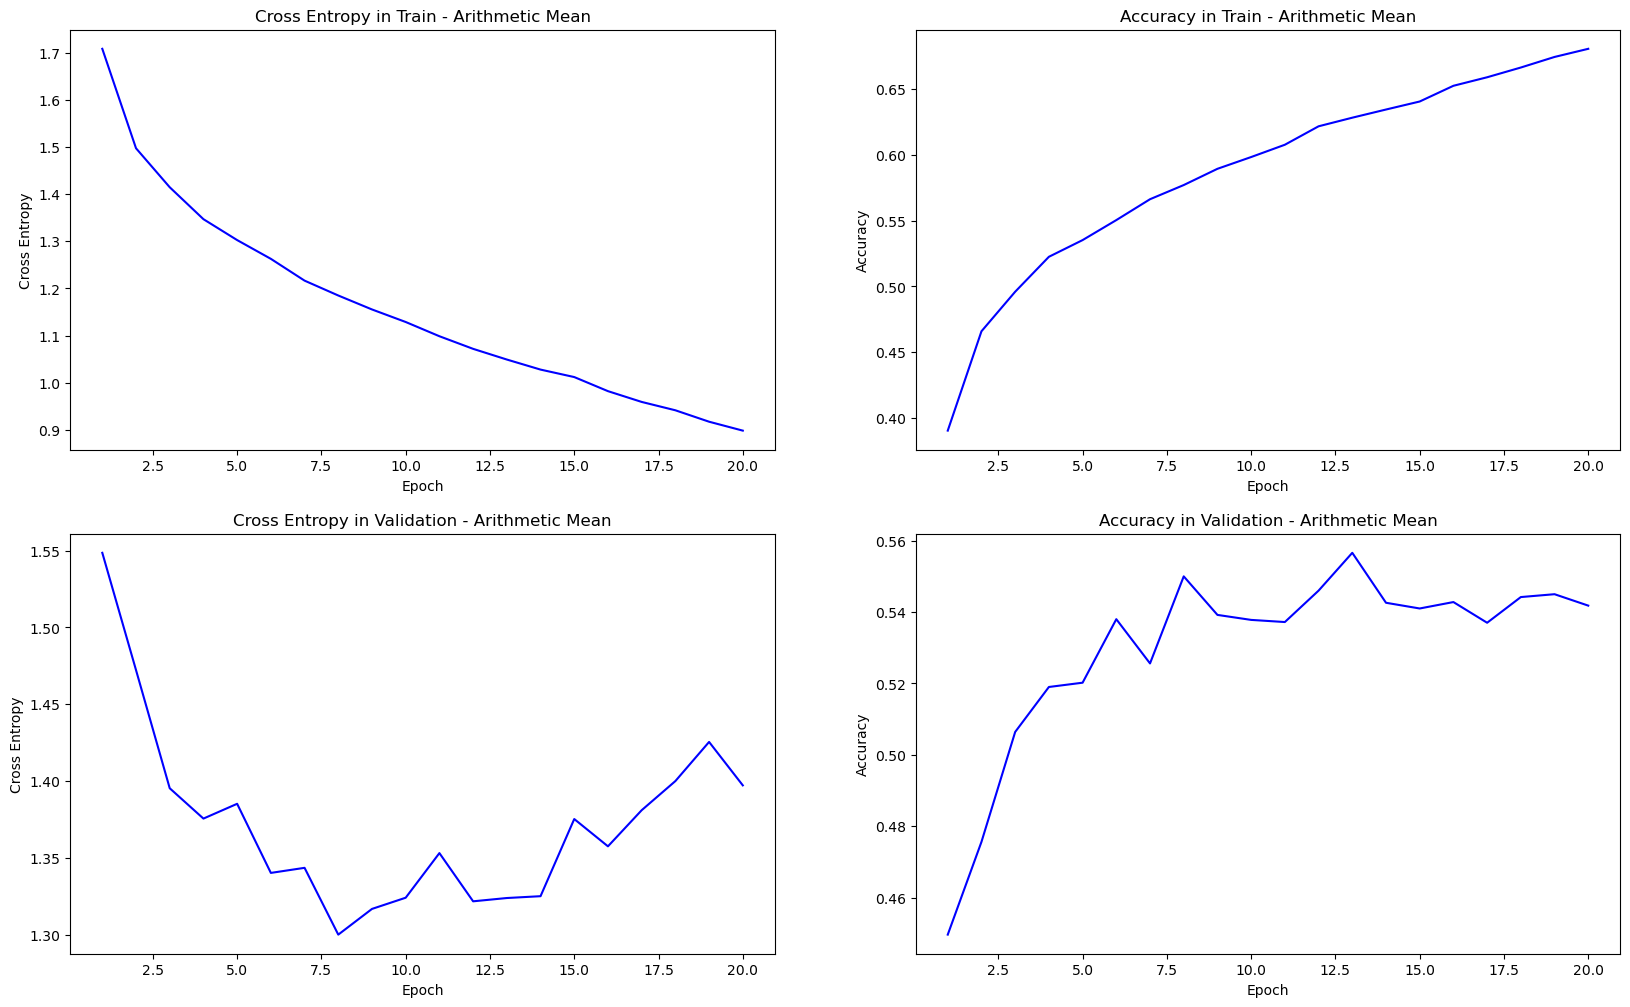

In [46]:
fig, ax = plt.subplots(2, 2, figsize = (20,12))

ax[0][0].plot(range(1,21), t_l_mean, color = "blue")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - Arithmetic Mean")

ax[0][1].plot(range(1,21), t_a_mean, color = "blue")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - Arithmetic Mean")

ax[1][0].plot(range(1,21), v_l_mean, color = "blue")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - Arithmetic Mean")

ax[1][1].plot(range(1,21), v_a_mean, color = "blue")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - Arithmetic Mean")


In [48]:
model = LeNetModel(minimum)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_minimum, t_l_minimum, t_a_minimum, v_l_minimum, v_a_minimum = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 1.435
Validation: epoch 1 - acc: 0.588
Training: [2,   704] loss: 1.095
Validation: epoch 2 - acc: 0.634
Training: [3,   704] loss: 0.958
Validation: epoch 3 - acc: 0.657
Training: [4,   704] loss: 0.872
Validation: epoch 4 - acc: 0.677
Training: [5,   704] loss: 0.807
Validation: epoch 5 - acc: 0.679
Training: [6,   704] loss: 0.751
Validation: epoch 6 - acc: 0.686
Training: [7,   704] loss: 0.695
Validation: epoch 7 - acc: 0.702
Training: [8,   704] loss: 0.650
Validation: epoch 8 - acc: 0.695
Training: [9,   704] loss: 0.608
Validation: epoch 9 - acc: 0.711
Training: [10,   704] loss: 0.566
Validation: epoch 10 - acc: 0.688
Training: [11,   704] loss: 0.537
Validation: epoch 11 - acc: 0.714
Training: [12,   704] loss: 0.508
Validation: epoch 12 - acc: 0.724
Training: [13,   704] loss: 0.476
Validation: epoch 13 - acc: 0.706
Training: [14,   704] loss: 0.439
Validation: epoch 14 - acc: 0.705
Training: [15,   704] loss: 0.422
Validation: epoch 15 - acc: 0.70

In [49]:
test(trained_model_minimum, test_loader, criterion, device='cuda')

Test - Accuracy: 0.703
Test - CrossEntropy: 1.130


Text(0.5, 1.0, 'Accuracy in Validation - Minimum')

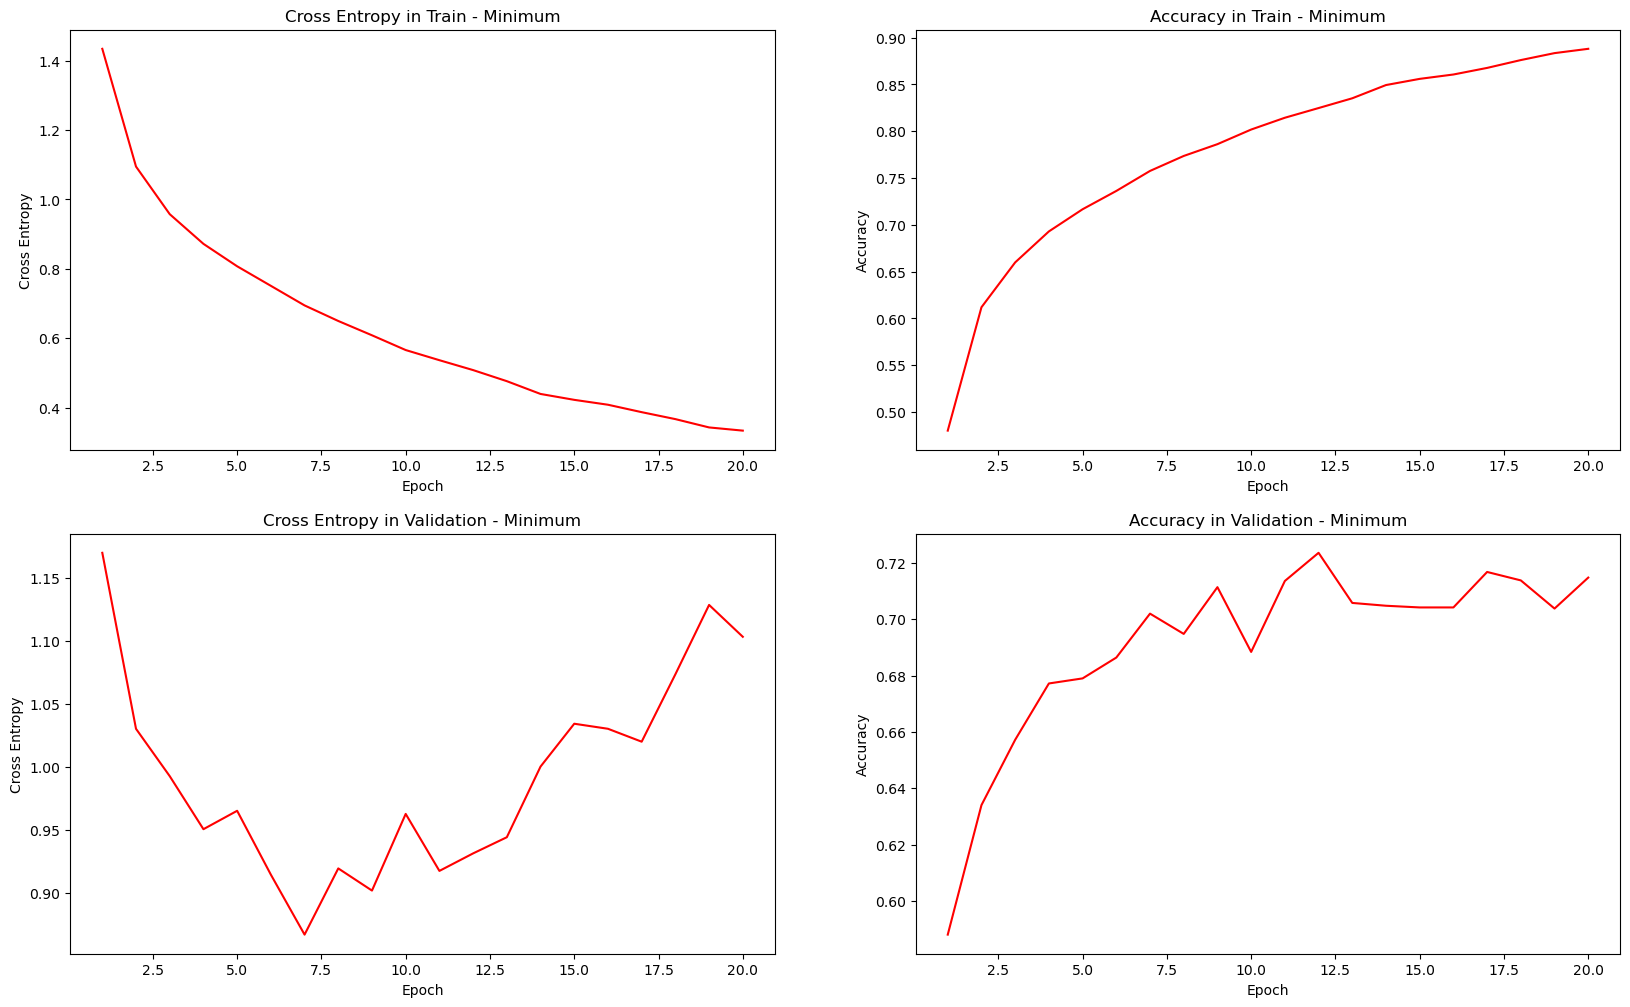

In [58]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_minimum, color = "red")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - Minimum")

ax[0][1].plot(range(1,21), t_a_minimum, color = "red")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - Minimum")

ax[1][0].plot(range(1,21), v_l_minimum, color = "red")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - Minimum")

ax[1][1].plot(range(1,21), v_a_minimum, color = "red")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - Minimum")

In [51]:
model = LeNetModel(product)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_prod, t_l_prod, t_a_prod, v_l_prod, v_a_prod = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 2.146
Validation: epoch 1 - acc: 0.290
Training: [2,   704] loss: 1.985
Validation: epoch 2 - acc: 0.285
Training: [3,   704] loss: 1.936
Validation: epoch 3 - acc: 0.246
Training: [4,   704] loss: 1.862
Validation: epoch 4 - acc: 0.331
Training: [5,   704] loss: 1.823
Validation: epoch 5 - acc: 0.372
Training: [6,   704] loss: 1.810
Validation: epoch 6 - acc: 0.178
Training: [7,   704] loss: 1.905
Validation: epoch 7 - acc: 0.393
Training: [8,   704] loss: 1.710
Validation: epoch 8 - acc: 0.394
Training: [9,   704] loss: 1.671
Validation: epoch 9 - acc: 0.404
Training: [10,   704] loss: 1.692
Validation: epoch 10 - acc: 0.398
Training: [11,   704] loss: 1.639
Validation: epoch 11 - acc: 0.421
Training: [12,   704] loss: 1.677
Validation: epoch 12 - acc: 0.376
Training: [13,   704] loss: 1.623
Validation: epoch 13 - acc: 0.413
Training: [14,   704] loss: 1.621
Validation: epoch 14 - acc: 0.410
Training: [15,   704] loss: 1.849
Validation: epoch 15 - acc: 0.10

In [52]:
test(trained_model_prod, test_loader, criterion, device='cuda')

Test - Accuracy: 0.100
Test - CrossEntropy: 2.303


Text(0.5, 1.0, 'Accuracy in Validation - Product')

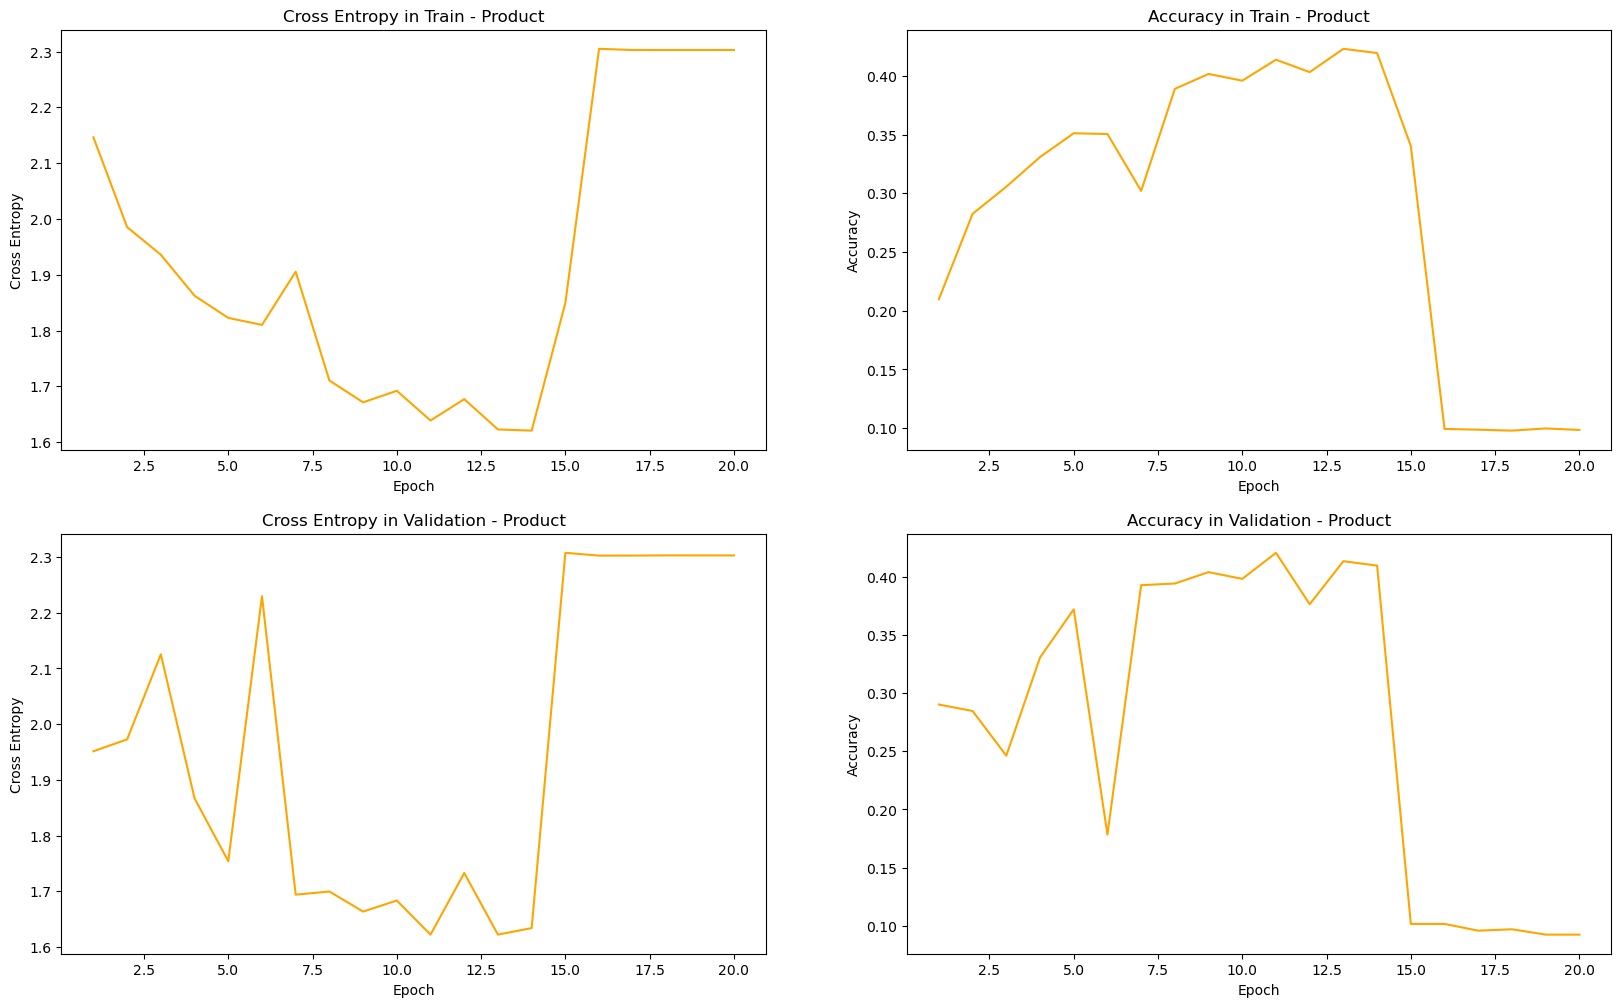

In [59]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_prod, color = "orange")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - Product")

ax[0][1].plot(range(1,21), t_a_prod, color = "orange")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - Product")

ax[1][0].plot(range(1,21), v_l_prod, color = "orange")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - Product")

ax[1][1].plot(range(1,21), v_a_prod, color = "orange")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - Product")

In [54]:
model = LeNetModel(t_norm_lukasiewicz)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_n_l, t_l_n_l, t_a_n_l, v_l_n_l, v_a_n_l = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 2.129
Validation: epoch 1 - acc: 0.339
Training: [2,   704] loss: 2.496
Validation: epoch 2 - acc: 0.103
Training: [3,   704] loss: 2.303
Validation: epoch 3 - acc: 0.103
Training: [4,   704] loss: 2.303
Validation: epoch 4 - acc: 0.097
Training: [5,   704] loss: 2.303
Validation: epoch 5 - acc: 0.092
Training: [6,   704] loss: 2.303
Validation: epoch 6 - acc: 0.092
Training: [7,   704] loss: 2.303
Validation: epoch 7 - acc: 0.092
Training: [8,   704] loss: 2.303
Validation: epoch 8 - acc: 0.096
Training: [9,   704] loss: 2.303
Validation: epoch 9 - acc: 0.096
Training: [10,   704] loss: 2.303
Validation: epoch 10 - acc: 0.096
Training: [11,   704] loss: 2.303
Validation: epoch 11 - acc: 0.100
Training: [12,   704] loss: 2.303
Validation: epoch 12 - acc: 0.092
Training: [13,   704] loss: 2.303
Validation: epoch 13 - acc: 0.092
Training: [14,   704] loss: 2.303
Validation: epoch 14 - acc: 0.092
Training: [15,   704] loss: 2.303
Validation: epoch 15 - acc: 0.09

In [55]:
test(trained_model_n_l, test_loader, criterion, device='cuda')

Test - Accuracy: 0.100
Test - CrossEntropy: 2.303


Text(0.5, 1.0, 'Accuracy in Validation - T-norm Lukasiewicz')

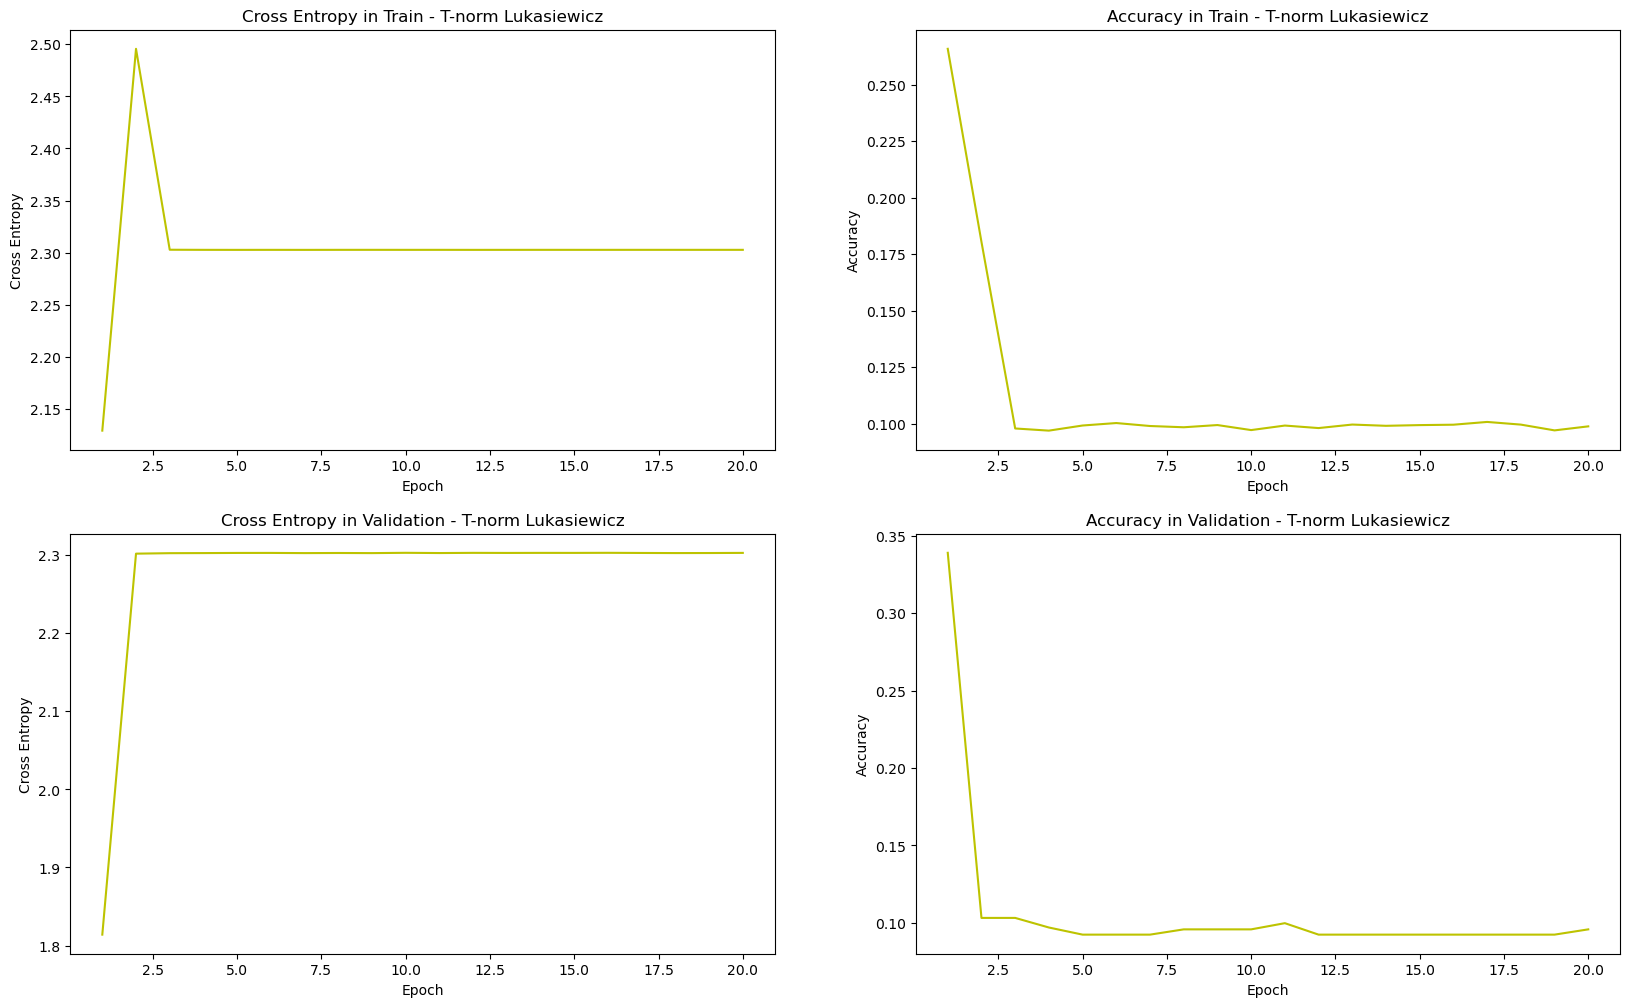

In [61]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_n_l, color = "#bdc300")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - T-norm Lukasiewicz")

ax[0][1].plot(range(1,21), t_a_n_l, color = "#bdc300")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - T-norm Lukasiewicz")

ax[1][0].plot(range(1,21), v_l_n_l, color = "#bdc300")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - T-norm Lukasiewicz")

ax[1][1].plot(range(1,21), v_a_n_l, color = "#bdc300")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - T-norm Lukasiewicz")

In [76]:
model = LeNetModel(t_norm_hamacher)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_n_h, t_l_n_h, t_a_n_h, v_l_n_h, v_a_n_h = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 2.088
Validation: epoch 1 - acc: 0.323
Training: [2,   704] loss: 1.852
Validation: epoch 2 - acc: 0.367
Training: [3,   704] loss: 1.727
Validation: epoch 3 - acc: 0.414
Training: [4,   704] loss: 1.680
Validation: epoch 4 - acc: 0.398
Training: [5,   704] loss: 1.637
Validation: epoch 5 - acc: 0.438
Training: [6,   704] loss: 1.671
Validation: epoch 6 - acc: 0.103
Training: [7,   704] loss: 2.303
Validation: epoch 7 - acc: 0.102
Training: [8,   704] loss: 2.303
Validation: epoch 8 - acc: 0.098
Training: [9,   704] loss: 2.303
Validation: epoch 9 - acc: 0.103
Training: [10,   704] loss: 2.303
Validation: epoch 10 - acc: 0.092
Training: [11,   704] loss: 2.303
Validation: epoch 11 - acc: 0.100
Training: [12,   704] loss: 2.303
Validation: epoch 12 - acc: 0.096
Training: [13,   704] loss: 2.303
Validation: epoch 13 - acc: 0.092
Training: [14,   704] loss: 2.303
Validation: epoch 14 - acc: 0.100
Training: [15,   704] loss: 2.303
Validation: epoch 15 - acc: 0.09

In [81]:
test(trained_model_n_h, test_loader, criterion, device='cuda')

Test - Accuracy: 0.100
Test - CrossEntropy: 2.303


Text(0.5, 1.0, 'Accuracy in Validation - T-norm Hamacker')

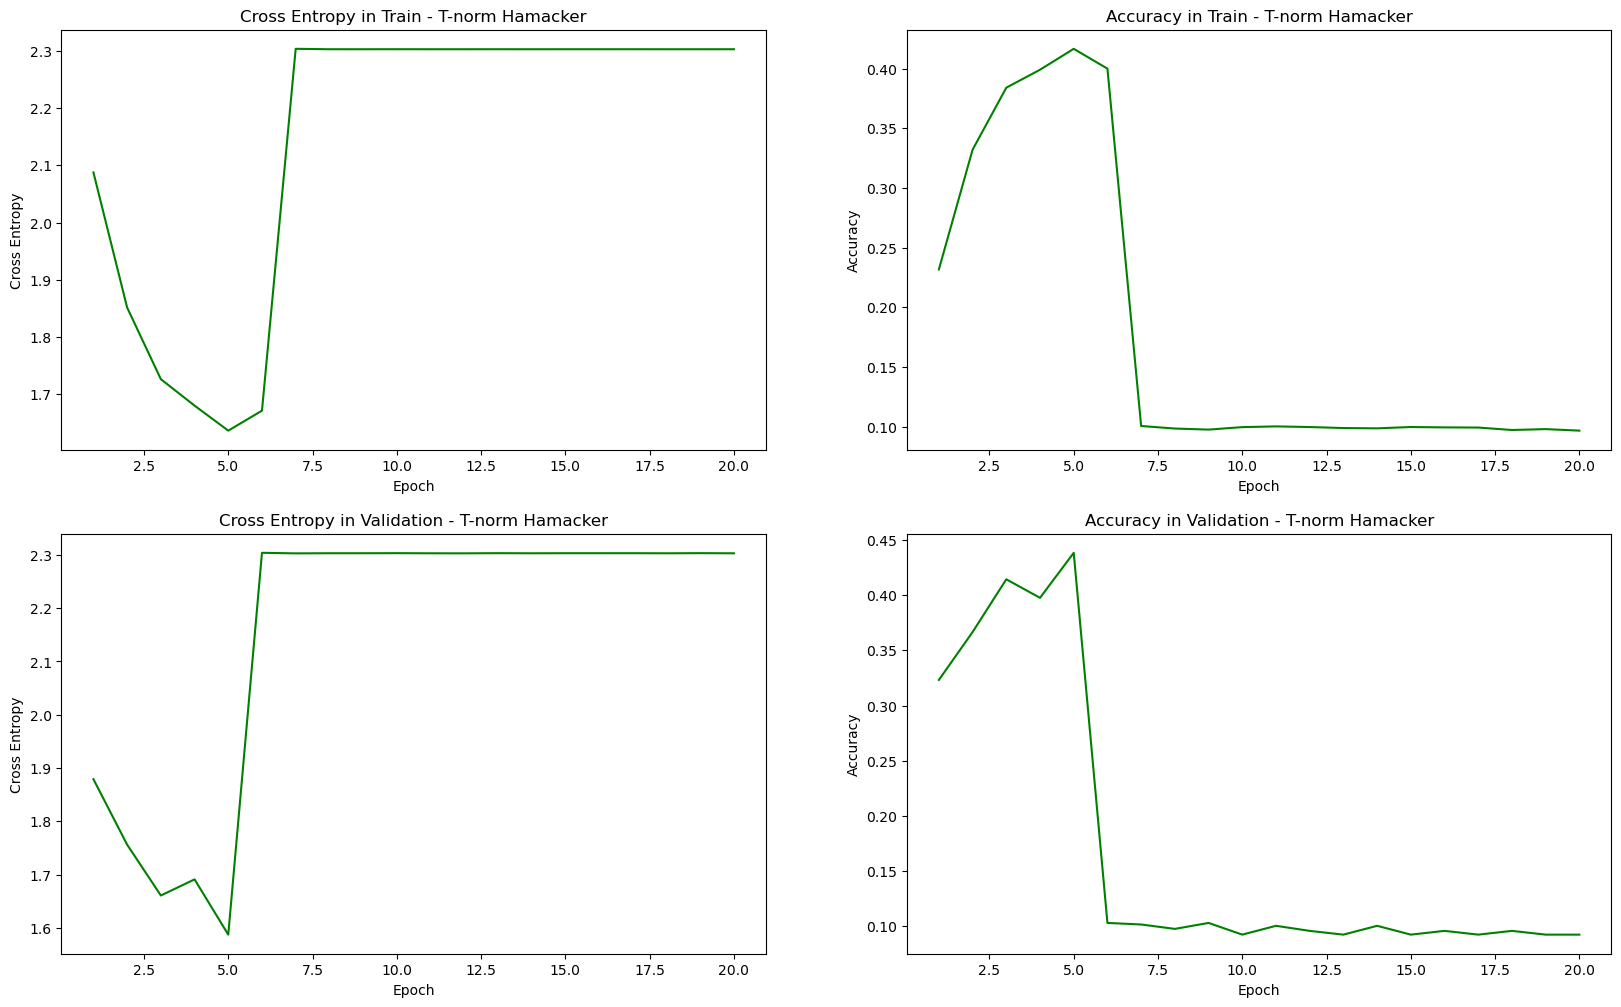

In [89]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_n_h, color = "green")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - T-norm Hamacker")

ax[0][1].plot(range(1,21), t_a_n_h, color = "green")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - T-norm Hamacker")

ax[1][0].plot(range(1,21), v_l_n_h, color = "green")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - T-norm Hamacker")

ax[1][1].plot(range(1,21), v_a_n_h, color = "green")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - T-norm Hamacker")

In [ ]:
model = LeNetModel(maximum)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_max, t_l_max, t_a_max, v_l_max, v_a_max = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

Training: [1,   704] loss: 1.425
Validation: epoch 1 - acc: 0.579
Training: [2,   704] loss: 1.077
Validation: epoch 2 - acc: 0.643
Training: [3,   704] loss: 0.952
Validation: epoch 3 - acc: 0.651
Training: [4,   704] loss: 0.859
Validation: epoch 4 - acc: 0.682
Training: [5,   704] loss: 0.805
Validation: epoch 5 - acc: 0.674
Training: [6,   704] loss: 0.741
Validation: epoch 6 - acc: 0.700
Training: [7,   704] loss: 0.687
Validation: epoch 7 - acc: 0.704
Training: [8,   704] loss: 0.645
Validation: epoch 8 - acc: 0.699
Training: [9,   704] loss: 0.601
Validation: epoch 9 - acc: 0.703
Training: [10,   704] loss: 0.572
Validation: epoch 10 - acc: 0.699
Training: [11,   704] loss: 0.538
Validation: epoch 11 - acc: 0.692
Training: [12,   704] loss: 0.501
Validation: epoch 12 - acc: 0.715
Training: [13,   704] loss: 0.473
Validation: epoch 13 - acc: 0.705
Training: [14,   704] loss: 0.444
Validation: epoch 14 - acc: 0.707
Training: [15,   704] loss: 0.421
Validation: epoch 15 - acc: 0.70

In [ ]:
test(trained_model_max, test_loader, criterion, device='cuda')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_max, color = "#0012c3")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - T-conorm Maximum")

ax[0][1].plot(range(1,21), t_a_max, color = "#0012c3")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - T-conorm Maximum")

ax[1][0].plot(range(1,21), v_l_max, color = "#0012c3")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - T-conorm Maximum")

ax[1][1].plot(range(1,21), v_a_max, color = "#0012c3")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - T-conorm Maximum")

In [ ]:
model = LeNetModel(t_conorm_lukasiewicz)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_c_l, t_l_c_l, t_a_c_l, v_l_c_l, v_a_c_l = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

In [ ]:
test(trained_model_c_l, test_loader, criterion, device='cuda')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_c_l, color = "#ba00c3")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - T-conorm Lukasiewicz")

ax[0][1].plot(range(1,21), t_a_c_l, color = "#ba00c3")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - T-conorm Lukasiewicz")

ax[1][0].plot(range(1,21), v_l_c_l, color = "#ba00c3")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - T-conorm Lukasiewicz")

ax[1][1].plot(range(1,21), v_a_c_l, color = "#ba00c3")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - T-conorm Lukasiewicz")

In [ ]:
model = LeNetModel(t_conorm_hamacher)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_c_h, t_l_c_h, t_a_c_h, v_l_c_h, v_a_c_h = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

In [ ]:
test(trained_model_c_h, test_loader, criterion, device='cuda')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_c_h, color = "#6200c3")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - T-conorm Hamacker")

ax[0][1].plot(range(1,21), t_a_c_h, color = "#6200c3")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - T-conorm Hamacker")

ax[1][0].plot(range(1,21), v_l_c_h, color = "#6200c3")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - T-conorm Hamacker")

ax[1][1].plot(range(1,21), v_a_c_h, color = "#6200c3")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - T-conorm Hamacker")

In [ ]:
model = LeNetModel(u_min_max)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_umm, t_l_umm, t_a_umm, v_l_umm, v_a_umm = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

In [ ]:
test(trained_model_umm, test_loader, criterion, device='cuda')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_umm, color = "#c3007f")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - Uninorm Min-Max")

ax[0][1].plot(range(1,21), t_a_umm, color = "#c3007f")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - Uninorm Min-Max")

ax[1][0].plot(range(1,21), v_l_umm, color = "#c3007f")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - Uninorm Min-Max")

ax[1][1].plot(range(1,21), v_a_umm, color = "#c3007f")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - Uninorm Min-Max")

In [ ]:
model = LeNetModel(u_l_l)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trained_model_ull, t_l_ull, t_a_ull, v_l_ull, v_a_ull = train(model, train_loader, criterion, optimizer, val_loader=val_loader)

In [ ]:
test(trained_model_ull, test_loader, criterion, device='cuda')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20, 12))

ax[0][0].plot(range(1,21), t_l_ull, color = "#00c3ab")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Cross Entropy")
ax[0][0].set_title("Cross Entropy in Train - Uninorm LL")

ax[0][1].plot(range(1,21), t_a_ull, color = "#00c3ab")
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("Accuracy in Train - Uninorm LL")

ax[1][0].plot(range(1,21), v_l_ull, color = "#00c3ab")
ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Cross Entropy")
ax[1][0].set_title("Cross Entropy in Validation - Uninorm LL")

ax[1][1].plot(range(1,21), v_a_ull, color = "#00c3ab")
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("Accuracy in Validation - Uninorm LL")